84814
307395
NaNs in RA1: 0
NaNs in DEC1: 0
NaNs in CZ1: 0
NaNs in RA2: 0
NaNs in DEC2: 0
NaNs in CZ2: 0


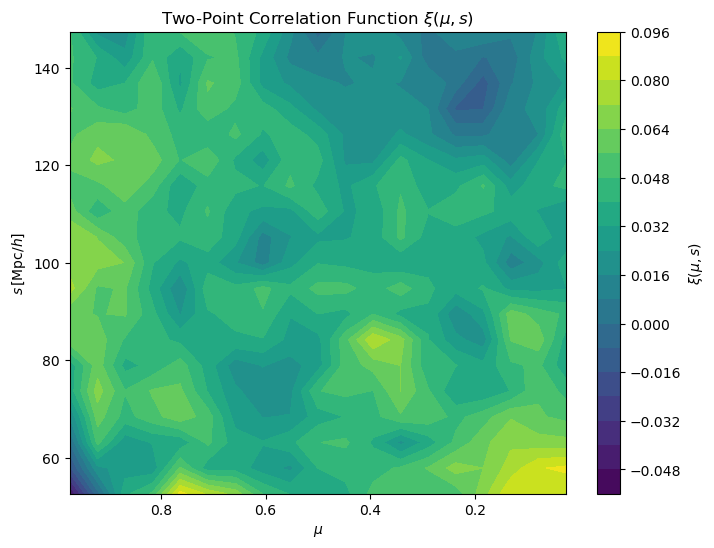

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.mocks import DDsmu_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
import pandas as pd 
import healpy as hp
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial

# Step 1: Read data and randoms
def read_data(zmin=0.05,zmax=0.15):
    # Load your data and randoms as Pandas DataFrames
    sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
    sdss  = sdss[(sdss["red"] > zmin)&(sdss["red"] < zmax)]
    return sdss

def read_randoms(filename):
    randoms = pd.read_csv(filename) 
    return randoms


# Step 3: Create random catalog
def build_cdf_from_parabola(data, num_points=10000):
    # Create a histogram of the redshifts
    vmin, vmax = data.min(), data.max()
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  
def generate_random_catalog(nrand, data, nside=128, write=False):
    """Generate a random catalog with uniform RA, DEC, and redshift."""
    # Set the resolution (nside)
    #nside = 128  # Approx 55 arcmin resolution (adjust as needed)
    #nrand = 20 # Times the size of the data (around 10% is left after mask)

    ra = data['ra'].values
    dec = data['dec'].values
    z = data['red'].values

    # Total number of pixels in the map
    npix = hp.nside2npix(nside)

    # Initialize a mask array (1 = valid, 0 = invalid)
    mask = np.zeros(npix, dtype=int)

    # Convert RA, Dec to Healpix indices
    theta = np.radians(90 - dec)  # Declination to colatitude
    phi = np.radians(ra)          # Right Ascension to longitude
    pixels = hp.ang2pix(nside, theta, phi)

    # Mark these pixels as valid
    mask[pixels] = 1

    num_randoms = len(ra)*nrand  # Number of random points

    # Generate uniform random RA, Dec
    ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
    dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

    # Convert RA, Dec to Healpix indices
    theta_random = np.radians(90 - dec_random)
    phi_random = np.radians(ra_random)
    random_pixels = hp.ang2pix(nside, theta_random, phi_random)

    # Apply the mask
    valid_indices = mask[random_pixels] == 1
    ra_random = ra_random[valid_indices]
    dec_random = dec_random[valid_indices]

    # Read redshift distribution and apply to randoms
    # Build the inverse CDF from a smoothed KDE fit
    cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(z)

    # Generate random redshifts
    u = np.random.uniform(0, 1, len(ra_random))
    red_random = cdf_inv_z(u)

    random_data = pd.DataFrame({
        'ra': ra_random,
        'dec': dec_random,
        'red': red_random
    })

    print(len(ra))
    print(len(ra_random))

    if write==True: random_data.to_csv(f'../data/random_sample_healpy_{nside}_{len(random_data)}.csv', index=False)

    return random_data

# Step 4: Run Corrfunc to compute xi(mu, s)
def calculate_xi_mu_s(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins, nmu_bins, nthreads=1):
    """Calculate xi(mu, s) using Corrfunc."""

    # Pair counts with Corrfunc
    DD_counts = DDsmu_mocks(1, 2, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_data, DEC1=dec_data, CZ1=3e5*z_data,\
            mu_max=1., nthreads=nthreads)
    DR_counts = DDsmu_mocks(0, 2, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_data, DEC1=dec_data, CZ1=3e5*z_data, RA2=ra_rand, DEC2=dec_rand, CZ2=3e5*z_rand,\
            mu_max=1., nthreads=nthreads)
    RR_counts = DDsmu_mocks(1, 2, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_rand, DEC1=dec_rand, CZ1=3e5*z_rand,\
            mu_max=1., nthreads=nthreads)

    # Convert to correlation function
    xi = convert_3d_counts_to_cf(len(ra_data), len(ra_data), len(ra_rand), len(ra_rand), \
        DD_counts, DR_counts, DR_counts, RR_counts)
    return xi


# Step 5: Plot xi(mu, s)
def plot_xi_mu_s_contours(xi, bins, nmu_bins, filename):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.savefig(filename)
    plt.close()

def plot_xil(filename):

    def get_xi0246(xi,mu,rs):
    
        import numpy as np
        

        nbins_s = len(rs)-1
        nbins_m = len(mu)

        xi = xi.reshape(nbins_s, nbins_m)

        xi_sm = xi

        dmu = 1.0/nbins_m
        
        #rs = corr.D1D2.coords['r']
        #mu = corr.D1D2.coords['mu']
        
        xi_s0 = np.zeros(nbins_s)
        xi_s2 = np.zeros(nbins_s)
        xi_s4 = np.zeros(nbins_s)
        xi_s6 = np.zeros(nbins_s)
        
        sr = np.zeros(nbins_s)
        rm = np.zeros(nbins_m)
        
        l0 = 0.0
        l1 = 1.0
        l2 = 2.0
        l3 = 3.0
        
        for i in range(nbins_s):
            
            sr[i] = rs[i]
            
            for j in range(nbins_m):
                rm[j]=mu[j]
                xi_s0[i]  += (4.0*l0+1.0)*xi_sm[i,j]*1.0*dmu 
                xi_s2[i]  += (4.0*l1+1.0)*xi_sm[i,j]*((3*rm[j]**2 - 1.0)/2.0)*dmu
                xi_s4[i]  += (4.0*l2+1.0)*xi_sm[i,j]*((35*rm[j]**4 - 30*rm[j]**2 + 3.0)/8.0)*dmu
                xi_s6[i]  += (4.0*l3+1.0)*xi_sm[i,j]*((231*rm[j]**6 - 315*rm[j]**4 + 105*rm[j]**2 - 5)/16.0)*dmu
        
        return xi_s0, xi_s2, xi_s4, xi_s6

    # Load the data from the .npz file
    file_path = filename+'.npz'
    data = np.load(file_path)

    s = data['s']  # Edges of s bins
    mu = data['mu']  # 
    xi = data['xi']  # Structured array for 2D correlation function

    xi_l = get_xi0246(xi,np.linspace(0,1,mu),s)

    #nr = 2.5+np.linspace(5.,150.,nbins_s+1)[:-1]
    r = bins[:-1]
    plt.plot(r,(xi_l[0])*r**2,label=r'$\xi_0$',c='C00')
    #plt.plot(r,(-xi_l[1]),label=r'$\xi_2$',c='C01')
    #plt.plot(r,(r**2)*(-xi_l[2]),label=r'$\xi_4$',c='C02')

    plt.xlabel('s')
    plt.ylabel(r'$s^2\xi_{\ell}$')
    plt.legend()
    plt.savefig(filename+'_xil.png')
    plt.close()

# Main execution
if __name__ == "__main__":

    import time

    t1=time.time()

    zmin, zmax = 0.05, 0.15
    nthreads = 128
    sample = 'allgxs' #['filgxs','nonfilgxs','allgxs']

    print(zmin,zmax,sample)

    # Read data
    sdss = read_data(zmin,zmax)

    # Select filament galaxies
    if sample=='filgxs': sdss = sdss[sdss['dist_fil']<=3.]
    if sample=='nonfilgxs': sdss = sdss[sdss['dist_fil']>=8.]

    # Generate Randoms
    randoms = generate_random_catalog(60, sdss, nside=128, write=False)

    # Dilute for testing
    #sdss = sdss.sample(n=40000)
    #randoms = randoms[:120000]

    # Calculate xi(mu, s)
    ra_data = sdss['ra'].values
    dec_data = sdss['dec'].values
    z_data = sdss['red'].values
    ra_rand = randoms['ra'].values
    dec_rand = randoms['dec'].values
    z_rand = randoms['red'].values
    bins = np.linspace(50, 150, 35)  # Separation bins in Mpc/h
    nmu_bins = len(bins)-1  # Number of mu bins
    xi = calculate_xi_mu_s(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins=bins, nmu_bins=nmu_bins, nthreads=nthreads)

    # Plot xi(mu, s)
    filename = f'2dcorr_corrfunc_{sample}_Nd{len(sdss)}_Nr{len(randoms)}'
    plot_xi_mu_s_contours(xi, bins, nmu_bins, filename+'.png')

    # Save results
    np.savez(filename+'.npz', xi=xi, s=bins, mu=nmu_bins)

    # PLot xi_l
    plot_xil(filename)

    t2 = time.time()

    print((t2-t1)/60,'min')

### Just Plots

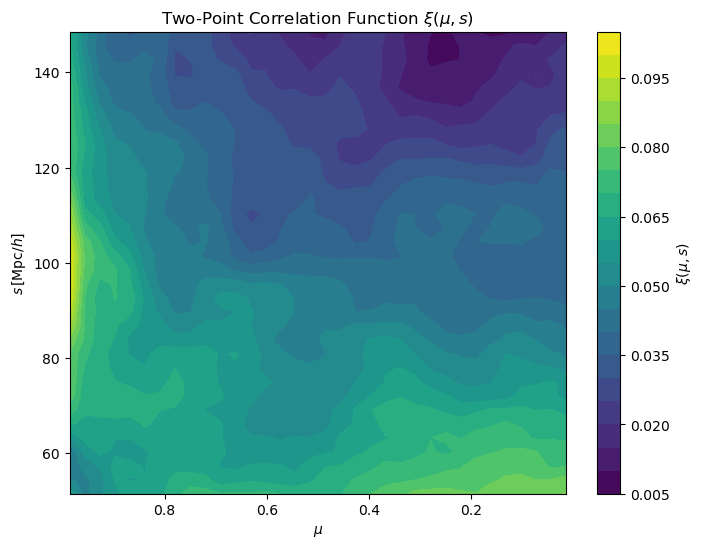

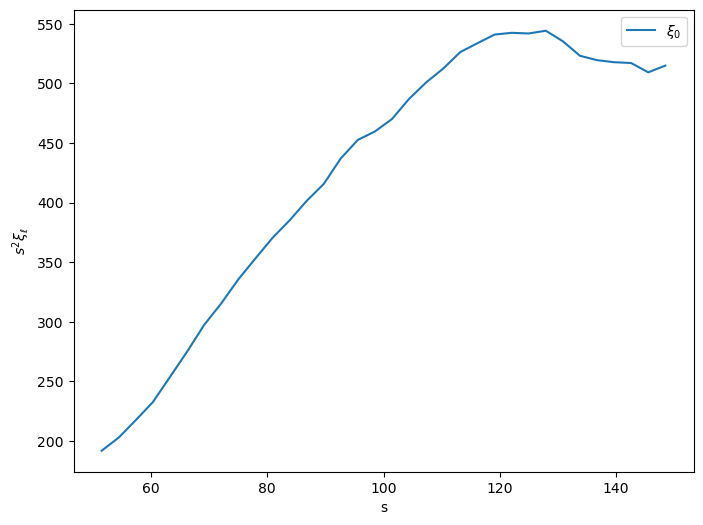

In [30]:
def plot_xi_mu_s_contours(xi, bins, nmu_bins, filename):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.savefig(filename)
    plt.show()

def plot_xil(filename):

    def get_xi0246(xi,mu,rs):
    
        import numpy as np
        

        nbins_s = len(rs)-1
        nbins_m = len(mu)

        xi = xi.reshape(nbins_s, nbins_m)

        xi_sm = xi

        dmu = 1.0/nbins_m
        
        #rs = corr.D1D2.coords['r']
        #mu = corr.D1D2.coords['mu']
        
        xi_s0 = np.zeros(nbins_s)
        xi_s2 = np.zeros(nbins_s)
        xi_s4 = np.zeros(nbins_s)
        xi_s6 = np.zeros(nbins_s)
        
        sr = np.zeros(nbins_s)
        rm = np.zeros(nbins_m)
        
        l0 = 0.0
        l1 = 1.0
        l2 = 2.0
        l3 = 3.0
        
        for i in range(nbins_s):
            
            sr[i] = rs[i]
            
            for j in range(nbins_m):
                rm[j]=mu[j]
                xi_s0[i]  += (4.0*l0+1.0)*xi_sm[i,j]*1.0*dmu 
                xi_s2[i]  += (4.0*l1+1.0)*xi_sm[i,j]*((3*rm[j]**2 - 1.0)/2.0)*dmu
                xi_s4[i]  += (4.0*l2+1.0)*xi_sm[i,j]*((35*rm[j]**4 - 30*rm[j]**2 + 3.0)/8.0)*dmu
                xi_s6[i]  += (4.0*l3+1.0)*xi_sm[i,j]*((231*rm[j]**6 - 315*rm[j]**4 + 105*rm[j]**2 - 5)/16.0)*dmu
        
        return xi_s0, xi_s2, xi_s4, xi_s6

    # Load the data from the .npz file
    file_path = filename+'.npz'
    data = np.load(file_path)

    s = data['s']  # Edges of s bins
    mu = data['mu']  # 
    xi = data['xi']  # Structured array for 2D correlation function

    xi_l = get_xi0246(xi,np.linspace(0,1,mu),s)

    #nr = 2.5+np.linspace(5.,150.,nbins_s+1)[:-1]
    r = bins[:-1]
    r = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    plt.figure(figsize=(8, 6))
    plt.plot(r,(xi_l[0])*r**2,label=r'$\xi_0$',c='C00')
    #plt.plot(r,(-xi_l[1]),label=r'$\xi_2$',c='C01')
    #plt.plot(r,(r**2)*(-xi_l[2]),label=r'$\xi_4$',c='C02')

    plt.xlabel('s')
    plt.ylabel(r'$s^2\xi_{\ell}$')
    plt.legend()
    plt.savefig(filename+'_xil.png')
    plt.show()

# Main execution
if __name__ == "__main__":

    import time

#    zmin, zmax = 0.05, 0.15
    sample = 'allgxs' #['filgxs','nonfilgxs','allgxs']

    filename = f'2dcorr_corrfunc_{sample}'

    data = np.load(filename+'.npz')
    xi = data['xi']
    s = data['s']
    mu = data['mu']

    # Plot xi(mu, s)
    plot_xi_mu_s_contours(xi, bins, nmu_bins, filename+'.png')

    # PLot xi_l
    plot_xil(filename)

### Just plots v2: distinta forma de calcular multipolos

In [59]:
import numpy as np
from scipy.special import legendre

def compute_multipoles(mu, s, xi_mu_s, ell_max=4):
    """
    Compute the multipoles of xi(mu, s) using Legendre polynomial expansion.
    
    Parameters:
    mu : 1D array
        Cosine of the angle values (should be sorted and equally spaced).
    s : 1D array
        Separation values.
    xi_mu_s : 2D array
        Correlation function values with shape (len(mu), len(s)).
    ell_max : int
        Maximum multipole order (default is 4, computes ell = 0, 2, 4).
    
    Returns:
    multipoles : dict
        Dictionary with keys as multipole orders and values as arrays of xi_ell(s).
    """
    dmu = mu[1] - mu[0]  # Assuming uniform spacing in mu
    multipoles = {}
    
    for ell in range(0, ell_max + 1, 2):  # Even multipoles only
        L_ell = legendre(ell)(mu)  # Evaluate Legendre polynomial at mu
        
        # Integrate over mu using the trapezoidal rule
        xi_ell_s = (4 * ell + 1) / 2 * np.trapz(xi_mu_s * L_ell[:, None], mu, axis=0)
        print(len(xi_ell_s))
        multipoles[ell] = xi_ell_s

    r = 0.5 * (s[:-1] + s[1:])  # Midpoints of s bins
    plt.figure(figsize=(8, 6))
    plt.plot(r,(multipoles[0])*r**2,label=r'$\xi_0$',c='C00')
    plt.plot(r,(-multipoles[2])*r**2,label=r'$\xi_2$',c='C01')
    #plt.plot(r,(r**2)*(-xi_l[2]),label=r'$\xi_4$',c='C02')

    plt.xlabel('s')
    plt.ylabel(r'$s^2\xi_{\ell}$')
    plt.legend()
    #plt.savefig(filename+'_xil.png')
    plt.show()

    
    return multipoles


def plot_xi_mu_s_contours(xi, bins, nmu_bins, filename):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.savefig(filename)
    plt.show()

# def plot_xil(filename):

#     def get_xi0246(xi,mu,rs):
    
#         import numpy as np
        

#         nbins_s = len(rs)-1
#         nbins_m = len(mu)

#         xi = xi.reshape(nbins_s, nbins_m)

#         xi_sm = xi

#         dmu = 1.0/nbins_m
        
#         #rs = corr.D1D2.coords['r']
#         #mu = corr.D1D2.coords['mu']
        
#         xi_s0 = np.zeros(nbins_s)
#         xi_s2 = np.zeros(nbins_s)
#         xi_s4 = np.zeros(nbins_s)
#         xi_s6 = np.zeros(nbins_s)
        
#         sr = np.zeros(nbins_s)
#         rm = np.zeros(nbins_m)
        
#         l0 = 0.0
#         l1 = 1.0
#         l2 = 2.0
#         l3 = 3.0
        
#         for i in range(nbins_s):
            
#             sr[i] = rs[i]
            
#             for j in range(nbins_m):
#                 rm[j]=mu[j]
#                 xi_s0[i]  += (4.0*l0+1.0)*xi_sm[i,j]*1.0*dmu 
#                 xi_s2[i]  += (4.0*l1+1.0)*xi_sm[i,j]*((3*rm[j]**2 - 1.0)/2.0)*dmu
#                 xi_s4[i]  += (4.0*l2+1.0)*xi_sm[i,j]*((35*rm[j]**4 - 30*rm[j]**2 + 3.0)/8.0)*dmu
#                 xi_s6[i]  += (4.0*l3+1.0)*xi_sm[i,j]*((231*rm[j]**6 - 315*rm[j]**4 + 105*rm[j]**2 - 5)/16.0)*dmu
        
#         return xi_s0, xi_s2, xi_s4, xi_s6

    # # Load the data from the .npz file
    # file_path = filename+'.npz'
    # data = np.load(file_path)

    # s = data['s']  # Edges of s bins
    # mu = data['mu']  # 
    # xi = data['xi']  # Structured array for 2D correlation function

    # xi_l = get_xi0246(xi,np.linspace(0,1,mu),s)

    # #nr = 2.5+np.linspace(5.,150.,nbins_s+1)[:-1]
    # r = bins[:-1]
    # r = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    # plt.figure(figsize=(8, 6))
    # plt.plot(r,(xi_l[0])*r**2,label=r'$\xi_0$',c='C00')
    # #plt.plot(r,(-xi_l[1]),label=r'$\xi_2$',c='C01')
    # #plt.plot(r,(r**2)*(-xi_l[2]),label=r'$\xi_4$',c='C02')

    # plt.xlabel('s')
    # plt.ylabel(r'$s^2\xi_{\ell}$')
    # plt.legend()
    # plt.savefig(filename+'_xil.png')
    # plt.show()

# Main execution
if __name__ == "__main__":

    import time

#    zmin, zmax = 0.05, 0.15
    sample = 'allgxs' #['filgxs','nonfilgxs','allgxs']

    filename = f'2dcorr_corrfunc_{sample}'

    data = np.load(filename+'.npz')
    xi = data['xi']
    s = data['s']
    nmu = data['mu']
    print(np.shape(xi))

    # Plot xi(mu, s)
    #plot_xi_mu_s_contours(xi, bins, nmu_bins, filename+'.png')

    mu = np.linspace(0,1,nmu)
    mu = 0.5*(mu[1:]+mu[:-1])

    multipoles = compute_multipoles(mu, s, xi.reshape(len(s)-1, nmu-1))


(1156,)


ValueError: cannot reshape array of size 1156 into shape (34,33)

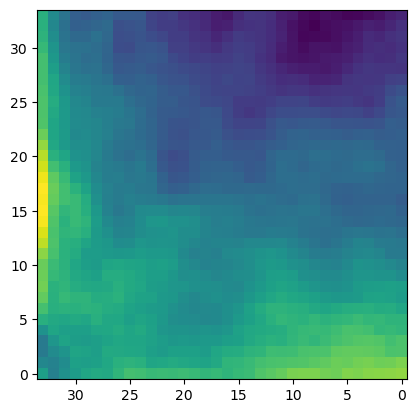

In [64]:
plt.imshow(xi.reshape(len(s)-1, nmu),origin='lower')
plt.gca().invert_xaxis()

### xi(rp,pi)

0.05 0.15 nonfilgxs
Generating randoms
data size: 177716
rand size: 1777160
Using 4 threads
Calculating DD


check_ra_dec_cz_double> Out of range values found for cz. Expected input to be `cz' but found `z' instead. max_cz (found in input) = 0.149968 threshold = 10.000000


Calculating DR
Calculating RR


check_ra_dec_cz_double> Out of range values found for cz. Expected input to be `cz' but found `z' instead. max_cz (found in input) = 0.149996 threshold = 10.000000


(30,)
(30,)
(30, 30)


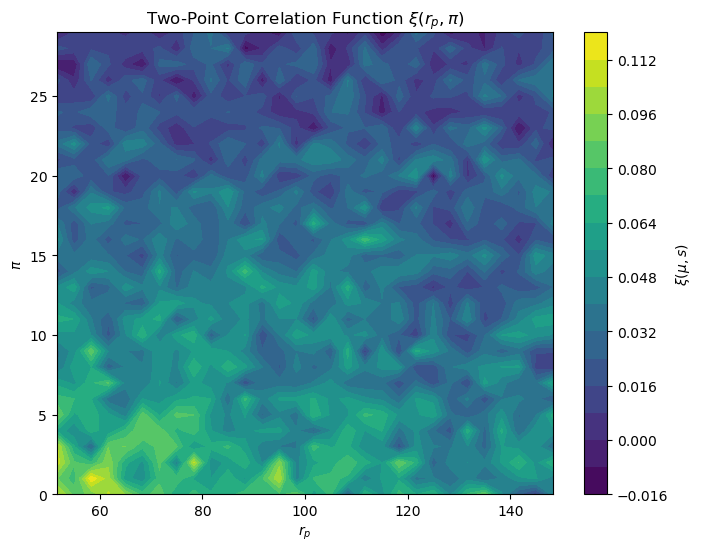

2.749451502164205 min


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.mocks import DDrppi_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
import pandas as pd 
import healpy as hp
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial

# Step 1: Read data and randoms
def read_data(zmin=0.05,zmax=0.15):
    # Load your data and randoms as Pandas DataFrames
    sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
    sdss  = sdss[(sdss["red"] > zmin)&(sdss["red"] < zmax)]
    return sdss

def read_randoms(filename):
    randoms = pd.read_csv(filename) 
    return randoms


# Step 3: Create random catalog
def build_cdf_from_parabola(data, num_points=10000):
    # Create a histogram of the redshifts
    vmin, vmax = data.min(), data.max()
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  
def generate_random_catalog(nrand, data, nside=128, write=False):
    """Generate a random catalog with uniform RA, DEC, and redshift."""
    # Set the resolution (nside)
    #nside = 128  # Approx 55 arcmin resolution (adjust as needed)
    #nrand = 20 # Times the size of the data (around 10% is left after mask)

    print('Generating randoms')

    ra = data['ra'].values
    dec = data['dec'].values
    z = data['red'].values

    # Total number of pixels in the map
    npix = hp.nside2npix(nside)

    # Initialize a mask array (1 = valid, 0 = invalid)
    mask = np.zeros(npix, dtype=int)

    # Convert RA, Dec to Healpix indices
    theta = np.radians(90 - dec)  # Declination to colatitude
    phi = np.radians(ra)          # Right Ascension to longitude
    pixels = hp.ang2pix(nside, theta, phi)

    # Mark these pixels as valid
    mask[pixels] = 1

    num_randoms = int(1e8)  # Number of random points

    # Generate uniform random RA, Dec
    ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
    dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

    # Convert RA, Dec to Healpix indices
    theta_random = np.radians(90 - dec_random)
    phi_random = np.radians(ra_random)
    random_pixels = hp.ang2pix(nside, theta_random, phi_random)

    # Apply the mask
    valid_indices = mask[random_pixels] == 1
    ra_random = ra_random[valid_indices][:nrand*len(data)]
    dec_random = dec_random[valid_indices][:nrand*len(data)]

    # Read redshift distribution and apply to randoms
    # Build the inverse CDF from a smoothed KDE fit
    cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(z)

    # Generate random redshifts
    u = np.random.uniform(0, 1, len(ra_random))
    red_random = cdf_inv_z(u)[:nrand*len(data)]

    random_data = pd.DataFrame({
        'ra': ra_random,
        'dec': dec_random,
        'red': red_random
    })

    print('data size:',len(ra))
    print('rand size:',len(ra_random))

    if write==True: random_data.to_csv(f'../data/random_sample_healpy_{nside}_{len(random_data)}.csv', index=False)

    return random_data

# Step 4: Run Corrfunc to compute xi(mu, s)
def calculate_xi_rp_pi(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins, pimax, nthreads=1):
    """Calculate xi(mu, s) using Corrfunc."""

    # Pair counts with Corrfunc
    print(f'Using {nthreads} threads')
    print('Calculating DD')
    DD_counts = DDrppi_mocks(1, 2, binfile=bins, pimax=pimax, \
        RA1=ra_data, DEC1=dec_data, CZ1=z_data,\
            nthreads=nthreads)
    print('Calculating DR')
    DR_counts = DDrppi_mocks(0, 2, binfile=bins, pimax=pimax, \
        RA1=ra_data, DEC1=dec_data, CZ1=z_data, RA2=ra_rand, DEC2=dec_rand, CZ2=3e5*z_rand,\
            nthreads=nthreads)
    print('Calculating RR')
    RR_counts = DDrppi_mocks(1, 2, binfile=bins, pimax=pimax, \
        RA1=ra_rand, DEC1=dec_rand, CZ1=z_rand,\
            nthreads=nthreads)

    # Convert to correlation function
    xi = convert_3d_counts_to_cf(len(ra_data), len(ra_data), len(ra_rand), len(ra_rand), \
        DD_counts, DR_counts, DR_counts, RR_counts)
    return xi


# Step 5: Plot xi(mu, s)
def plot_xi_rp_pi_contours(xi, bins, pimax, filename):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    rp_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    #rp_bins = bins
    pi_bins = np.arange(0, pimax)
    #pi_bins_centers = 0.5 * (pi_bins[:-1] + pi_bins[1:])  # Midpoints of mu bins
    pi_bins_centers = pi_bins
    print(np.shape(rp_bins))
    print(np.shape(pi_bins_centers))

    xi = xi.reshape(len(rp_bins), len(pi_bins))

    print(np.shape(xi))

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(rp_bins, pi_bins_centers, xi, levels=20, cmap='viridis')  
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.xlabel(r'$r_p$')  # Negative mu since it's inverted
    plt.ylabel(r'$\pi$')
    plt.title(r'Two-Point Correlation Function $\xi(r_p, \pi)$')
    plt.show()
    #plt.savefig(filename)
    #plt.close()

# def plot_xil(filename):

#     def get_xi0246(xi,mu,rs):
    
#         import numpy as np
        

#         nbins_s = len(rs)-1
#         nbins_m = len(mu)

#         xi = xi.reshape(nbins_s, nbins_m)

#         xi_sm = xi

#         dmu = 1.0/nbins_m
        
#         #rs = corr.D1D2.coords['r']
#         #mu = corr.D1D2.coords['mu']
        
#         xi_s0 = np.zeros(nbins_s)
#         xi_s2 = np.zeros(nbins_s)
#         xi_s4 = np.zeros(nbins_s)
#         xi_s6 = np.zeros(nbins_s)
        
#         sr = np.zeros(nbins_s)
#         rm = np.zeros(nbins_m)
        
#         l0 = 0.0
#         l1 = 1.0
#         l2 = 2.0
#         l3 = 3.0
        
#         for i in range(nbins_s):
            
#             sr[i] = rs[i]
            
#             for j in range(nbins_m):
#                 rm[j]=mu[j]
#                 xi_s0[i]  += (4.0*l0+1.0)*xi_sm[i,j]*1.0*dmu 
#                 xi_s2[i]  += (4.0*l1+1.0)*xi_sm[i,j]*((3*rm[j]**2 - 1.0)/2.0)*dmu
#                 xi_s4[i]  += (4.0*l2+1.0)*xi_sm[i,j]*((35*rm[j]**4 - 30*rm[j]**2 + 3.0)/8.0)*dmu
#                 xi_s6[i]  += (4.0*l3+1.0)*xi_sm[i,j]*((231*rm[j]**6 - 315*rm[j]**4 + 105*rm[j]**2 - 5)/16.0)*dmu
        
#         return xi_s0, xi_s2, xi_s4, xi_s6

#     # Load the data from the .npz file
#     file_path = filename+'.npz'
#     data = np.load(file_path)

#     s = data['s']  # Edges of s bins
#     mu = data['mu']  # 
#     xi = data['xi']  # Structured array for 2D correlation function

#     xi_l = get_xi0246(xi,np.linspace(0,1,mu),s)

#     #nr = 2.5+np.linspace(5.,150.,nbins_s+1)[:-1]
#     r = bins[:-1]
#     plt.plot(r,(xi_l[0])*r**2,label=r'$\xi_0$',c='C00')
#     #plt.plot(r,(-xi_l[1]),label=r'$\xi_2$',c='C01')
#     #plt.plot(r,(r**2)*(-xi_l[2]),label=r'$\xi_4$',c='C02')

#     plt.xlabel('s')
#     plt.ylabel(r'$s^2\xi_{\ell}$')
#     plt.legend()
#     plt.savefig(filename+'_xil.png')
#     plt.close()

# Main execution
if __name__ == "__main__":

    import time

    t1=time.time()

    zmin, zmax = 0.05, 0.15
    nthreads = 4
    sample = 'nonfilgxs' #['filgxs','nonfilgxs','allgxs']
    nrand = 10 # times the size of the data catalogue

    print(zmin,zmax,sample)

    # Read data
    sdss = read_data(zmin,zmax)

    # Select filament galaxies
    if sample=='filgxs': sdss = sdss[sdss['dist_fil']<=3.]
    if sample=='nonfilgxs': sdss = sdss[sdss['dist_fil']>=8.]

    # Generate Randoms
    randoms = generate_random_catalog(nrand, sdss, nside=128, write=False)

    # Dilute for testing
    sdss = sdss.sample(n=20000)
    randoms = randoms[:40000]

    # Calculate xi(mu, s)
    ra_data = sdss['ra'].values
    dec_data = sdss['dec'].values
    z_data = sdss['red'].values
    ra_rand = randoms['ra'].values
    dec_rand = randoms['dec'].values
    z_rand = randoms['red'].values
    nbins = 30
    bins = np.linspace(50, 150, nbins+1)  # Separation bins in Mpc/h
    pimax = nbins  # 
    xi = calculate_xi_rp_pi(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins=bins, pimax=pimax, nthreads=nthreads)

    # Plot xi(mu, s)
    filename = f'rppi_corrfunc_{sample}_Nd{len(sdss)}_Nr{len(randoms)}'
    plot_xi_rp_pi_contours(xi, bins, pimax, filename+'.png')

    # Save results
    #np.savez(filename+'.npz', xi=xi, rp=bins, pimax=pimax)

    # PLot xi_l
    #plot_xil(filename)

    t2 = time.time()

    print((t2-t1)/60,'min')

In [ ]:
xi


array([ 0.09529642,  0.06487118,  0.06390689,  0.05223489,  0.06484515,
        0.08106105,  0.04297639,  0.05825547,  0.06434978,  0.05690342,
        0.06416635,  0.05935617,  0.06572873,  0.08993535,  0.06238125,
        0.08418155,  0.07503201,  0.04064671,  0.04911515,  0.06858085,
        0.06938616,  0.04610183,  0.04017387,  0.0911959 ,  0.04889621,
        0.02146975,  0.03246108,  0.04587895,  0.05689696,  0.08620575,
        0.06261926,  0.07127681,  0.08777485,  0.04205219,  0.05021802,
        0.06981381,  0.07132974,  0.0457493 ,  0.04564989,  0.08809189,
        0.06593704,  0.05924335,  0.02838927,  0.05619207,  0.05245532,
        0.09063182,  0.08451995,  0.0827842 ,  0.03826853,  0.07088576,
        0.06052484,  0.04118822,  0.05049566,  0.07644917,  0.03224802,
        0.02382303,  0.06330872,  0.03835443,  0.04196276,  0.03182343,
        0.0500846 ,  0.07664704,  0.07058724,  0.05986425,  0.04881285,
        0.05552567,  0.039722  ,  0.0762982 ,  0.03205661,  0.09

#### Pruebita para ver si lo que devuelve Corrfunc está en Mpc o Mpc/h

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.mocks import DDrppi_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
import pandas as pd 
import healpy as hp
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial

# Step 1: Read data and randoms
def read_data(zmin=0.05,zmax=0.15):
    # Load your data and randoms as Pandas DataFrames
    sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
    sdss  = sdss[(sdss["red"] > zmin)&(sdss["red"] < zmax)]
    return sdss

def read_randoms(filename):
    randoms = pd.read_csv(filename) 
    return randoms


# Step 3: Create random catalog
def build_cdf_from_parabola(data, num_points=10000):
    # Create a histogram of the redshifts
    vmin, vmax = data.min(), data.max()
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  
def generate_random_catalog(nrand, data, nside=128, write=False):
    """Generate a random catalog with uniform RA, DEC, and redshift."""
    # Set the resolution (nside)
    #nside = 128  # Approx 55 arcmin resolution (adjust as needed)
    #nrand = 20 # Times the size of the data (around 10% is left after mask)

    print('Generating randoms')

    ra = data['ra'].values
    dec = data['dec'].values
    z = data['red'].values

    # Total number of pixels in the map
    npix = hp.nside2npix(nside)

    # Initialize a mask array (1 = valid, 0 = invalid)
    mask = np.zeros(npix, dtype=int)

    # Convert RA, Dec to Healpix indices
    theta = np.radians(90 - dec)  # Declination to colatitude
    phi = np.radians(ra)          # Right Ascension to longitude
    pixels = hp.ang2pix(nside, theta, phi)

    # Mark these pixels as valid
    mask[pixels] = 1

    num_randoms = int(1e8)  # Number of random points

    # Generate uniform random RA, Dec
    ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
    dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

    # Convert RA, Dec to Healpix indices
    theta_random = np.radians(90 - dec_random)
    phi_random = np.radians(ra_random)
    random_pixels = hp.ang2pix(nside, theta_random, phi_random)

    # Apply the mask
    valid_indices = mask[random_pixels] == 1
    ra_random = ra_random[valid_indices][:nrand*len(data)]
    dec_random = dec_random[valid_indices][:nrand*len(data)]

    # Read redshift distribution and apply to randoms
    # Build the inverse CDF from a smoothed KDE fit
    cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(z)

    # Generate random redshifts
    u = np.random.uniform(0, 1, len(ra_random))
    red_random = cdf_inv_z(u)[:nrand*len(data)]

    random_data = pd.DataFrame({
        'ra': ra_random,
        'dec': dec_random,
        'red': red_random
    })

    print('data size:',len(ra))
    print('rand size:',len(ra_random))

    if write==True: random_data.to_csv(f'../data/random_sample_healpy_{nside}_{len(random_data)}.csv', index=False)

    return random_data

# Step 4: Run Corrfunc to compute xi(mu, s)
def calculate_xi_rp_pi(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins, pimax, nthreads=1):
    """Calculate xi(mu, s) using Corrfunc."""

    # Pair counts with Corrfunc
    print(f'Using {nthreads} threads')
    print('Calculating DD')
    DD_counts = DDrppi_mocks(1, 2, binfile=bins, pimax=pimax, \
        RA1=ra_data, DEC1=dec_data, CZ1=z_data,\
            nthreads=nthreads)
    print('Calculating DR')
    DR_counts = DDrppi_mocks(0, 2, binfile=bins, pimax=pimax, \
        RA1=ra_data, DEC1=dec_data, CZ1=z_data, RA2=ra_rand, DEC2=dec_rand, CZ2=3e5*z_rand,\
            nthreads=nthreads)
    print('Calculating RR')
    RR_counts = DDrppi_mocks(1, 2, binfile=bins, pimax=pimax, \
        RA1=ra_rand, DEC1=dec_rand, CZ1=z_rand,\
            nthreads=nthreads)

    # Convert to correlation function
    xi = convert_3d_counts_to_cf(len(ra_data), len(ra_data), len(ra_rand), len(ra_rand), \
        DD_counts, DR_counts, DR_counts, RR_counts)
    return xi


# Step 5: Plot xi(mu, s)
def plot_xi_rp_pi_contours(xi, bins, pimax, filename):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    rp_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    #rp_bins = bins
    pi_bins = np.arange(0, pimax)
    #pi_bins_centers = 0.5 * (pi_bins[:-1] + pi_bins[1:])  # Midpoints of mu bins
    pi_bins_centers = pi_bins
    print(np.shape(rp_bins))
    print(np.shape(pi_bins_centers))

    xi = xi.reshape(len(rp_bins), len(pi_bins))

    print(np.shape(xi))

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(rp_bins, pi_bins_centers, xi, levels=20, cmap='viridis')  
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.xlabel(r'$r_p$')  # Negative mu since it's inverted
    plt.ylabel(r'$\pi$')
    plt.title(r'Two-Point Correlation Function $\xi(r_p, \pi)$')
    plt.show()
    #plt.savefig(filename)
    #plt.close()



# Main execution
if __name__ == "__main__":

    import astropy.constants as const
    import astropy.units as u
    cvel = const.c.to(u.km/u.second).value

    zmin, zmax = 0.05, 0.15
    nthreads = 1
    sample = 'nonfilgxs' #['filgxs','nonfilgxs','allgxs']
    nrand = 10 # times the size of the data catalogue

    print(zmin,zmax,sample)

    # Read data
    sdss = read_data(zmin,zmax)

    # Select filament galaxies
    if sample=='filgxs': sdss = sdss[sdss['dist_fil']<=3.]
    if sample=='nonfilgxs': sdss = sdss[sdss['dist_fil']>=8.]

    # Generate Randoms
    #randoms = generate_random_catalog(nrand, sdss, nside=128, write=False)

    # Dilute for testing
    #sdss = sdss.sample(n=20000)
    #randoms = randoms[:40000]

    # Calculate xi(mu, s)
    ra_data = sdss['ra'].values
    dec_data = sdss['dec'].values
    z_data = sdss['red'].values
    #ra_rand = randoms['ra'].values
    #dec_rand = randoms['dec'].values
    #z_rand = randoms['red'].values
    nbins = 10
    bins = np.linspace(10, 50, nbins+1)  # Separation bins in Mpc/h
    pimax = nbins  # 
    #xi = calculate_xi_rp_pi(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins=bins, pimax=pimax, nthreads=nthreads)

    print('normal')
    # DDpairs_normal = DDrppi_mocks(1, 2, binfile=bins, pimax=pimax, \
    #     RA1=ra_data, DEC1=dec_data, CZ1=z_data,\
    #         nthreads=nthreads)

    print('c*z')
    DDpairs_withC = DDrppi_mocks(1, 2, binfile=bins, pimax=pimax, \
        RA1=ra_data, DEC1=dec_data, CZ1=cvel*z_data,\
            nthreads=nthreads)

    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=67.0, Om0=0.302)
    CZ1 = cosmo.comoving_distance(z_data).value
    print('Custom Cosmology')
    DDpairs_customCosmo = DDrppi_mocks(1, 2, binfile=bins, pimax=pimax, \
        RA1=ra_data, DEC1=dec_data, CZ1=CZ1,\
            nthreads=nthreads, is_comoving_dist=True)

    # Plot xi(mu, s)
    #filename = f'rppi_corrfunc_{sample}_Nd{len(sdss)}_Nr{len(randoms)}'
    #plot_xi_rp_pi_contours(xi, bins, pimax, filename+'.png')



0.05 0.15 nonfilgxs
normal
c*z
Custom Cosmology


In [23]:
np.sqrt(np.sum((np.int64(DDpairs_withC['npairs'])-np.int64(DDpairs_customCosmo['npairs']))**2))


7231540.62223037

In [11]:
print(DDpairs_customCosmo)

[(10.        , 12.66666667, 0.,  1.,  4162, 0.)
 (10.        , 12.66666667, 0.,  2.,  4176, 0.)
 (10.        , 12.66666667, 0.,  3.,  3990, 0.)
 (10.        , 12.66666667, 0.,  4.,  4168, 0.)
 (10.        , 12.66666667, 0.,  5.,  4184, 0.)
 (10.        , 12.66666667, 0.,  6.,  4066, 0.)
 (10.        , 12.66666667, 0.,  7.,  3860, 0.)
 (10.        , 12.66666667, 0.,  8.,  3844, 0.)
 (10.        , 12.66666667, 0.,  9.,  3740, 0.)
 (10.        , 12.66666667, 0., 10.,  3722, 0.)
 (10.        , 12.66666667, 0., 11.,  3490, 0.)
 (10.        , 12.66666667, 0., 12.,  3632, 0.)
 (10.        , 12.66666667, 0., 13.,  3432, 0.)
 (10.        , 12.66666667, 0., 14.,  3680, 0.)
 (10.        , 12.66666667, 0., 15.,  3538, 0.)
 (12.66666667, 15.33333333, 0.,  1.,  4904, 0.)
 (12.66666667, 15.33333333, 0.,  2.,  4716, 0.)
 (12.66666667, 15.33333333, 0.,  3.,  4684, 0.)
 (12.66666667, 15.33333333, 0.,  4.,  4704, 0.)
 (12.66666667, 15.33333333, 0.,  5.,  4616, 0.)
 (12.66666667, 15.33333333, 0.,  6.,  47